## Homework Three: Extending the Linear Regression Framework

In this homework, we will extend our understanding of linear regression by considering how using a **held-out test set** can help determine how well the model 
generalizes to unseen data. Next week, we will refine this approach further by distinguishing between validation and testing sets.

Secondly, we will extend the linear regression framework by generalizing the basic idea of polynomial regression: we will perform **feature engineering** by
adding new features computed from the originals using log scaling and other non-linear functions. 

**Notes:**

- **You will NO LONGER need to submit a `requirements.txt` file!**

- **Grading:** There are nine (9) graded questions, each worth 6 points. You will be given 2 bonus points for free to bring this up to a total of 50 points for the whole assignment. 

In [1]:
# Useful imports and utilities

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
import kagglehub
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing,make_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

from tqdm import tqdm
from math import isclose

# globals

random_state = 42



c:\Users\JT von Seggern\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Problem One:  Model Selection using Test Sets

This week’s video explores the challenge of model selection in polynomial regression: how do we determine the best polynomial degree for our data? As we saw, increasing model complexity (in this case, polynomial degree) generally reduces training MSE. However, this does not necessarily mean better generalization, so: 

- How do we select a model that performs well on new data?
- How do we strike the right balance between:
   - Underfitting (high bias, low variance), and
   - Overfitting (low bias, high variance)?

To address this, we introduce **testing sets** and examine how evaluating models on unseen data provides a more reliable measure of generalization. 

### Part A

The following function will generate datasets suitable for polynomial regression with various characteristics:

- `n_samples`: number of samples
- `degree`: degree of the underlying polynomial model (with no noise)
- `noise`: standard deviation of the noise added to the model
- `show_data`, `show_model`: whether to show a plot of the dataset and the underlying model
- `random_state`: random seed which controls how random choices are made; set to None if you want a different set of choices each time

Your first task, as usual, is to play around with this a bit, changing the parameters in the call in the last line. There is no coding to be done (yet). 

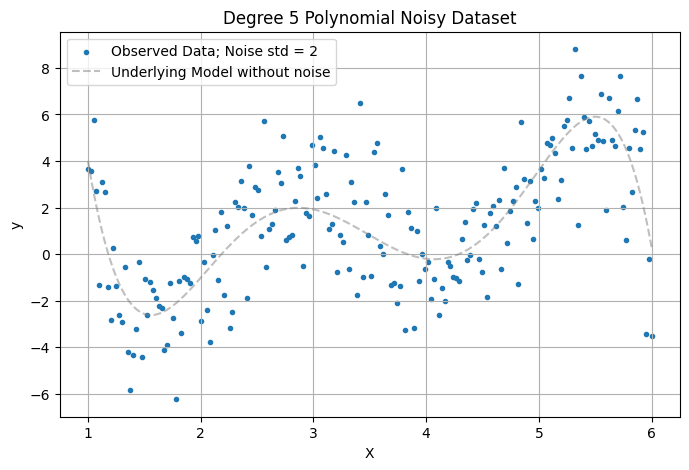

In [2]:
def make_poly_model(n_samples=10, degree=4,noise=1.0, show_data=False, show_model=True,random_state=random_state):
    
    lb,ub = 1,6

    def f(x):
        if degree==2:
            return 0.125*x**2 - 0.95*x + 1.925 
        elif degree==3:
            return 0.125*x**3 - 1.2*x**2 + 3*x + 0.5   
        elif degree==4:
            return 0.41*x**4 - 5.99*x**3 + 30.55*x**2 - 62.37*x + 41.4
        elif degree==5:
            return  -0.4*x**5 + 7.0*x**4 - 46.17*x**3 + 142.0*x**2 - 200.43*x + 102.0 
        elif degree==6:
            return -0.5219*x**6 + 10.7724*x**5 - 87.6206*x**4 + 355.7914*x**3 - 751.5246*x**2 + 774.0203*x - 300.917
        else:
            print("Degree must be in range [2..6]")
            return None
            
    X_all = np.linspace(lb,ub,1000)
    y_perfect_model = f(X_all)
    

    np.random.seed(random_state)
    X = np.linspace(lb,ub,n_samples)             # evenly spaced samples for simplicity
    y = f(X) + np.random.normal(0, noise,size=n_samples)

    # Plotting the scatter plot of the data 

    if show_data:
      
        plt.figure(figsize=(8, 5))
        plt.scatter(X, y, marker='.',label=f'Observed Data; Noise std = {noise}')
        if show_model:
            plt.plot(X_all, y_perfect_model, label='Underlying Model without noise', linestyle='--',color='grey', alpha=0.5)
        plt.xlabel('X')
        plt.ylabel('y')
        plt.title(f'Degree {degree} Polynomial Noisy Dataset')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    return X.reshape(-1,1),y

    
X,y = make_poly_model(n_samples=200,degree=5,noise=2,show_data=True,random_state=None)

### Part B: Create a dataset with the following parameters:

    n_samples=200
    degree = 5
    noise=10
    test_size = 0.3
    random_state = 42

Leave the others at the defaults and then split it into four subsets using 
sklearn's `test_train_split`; your results should match the test case. 

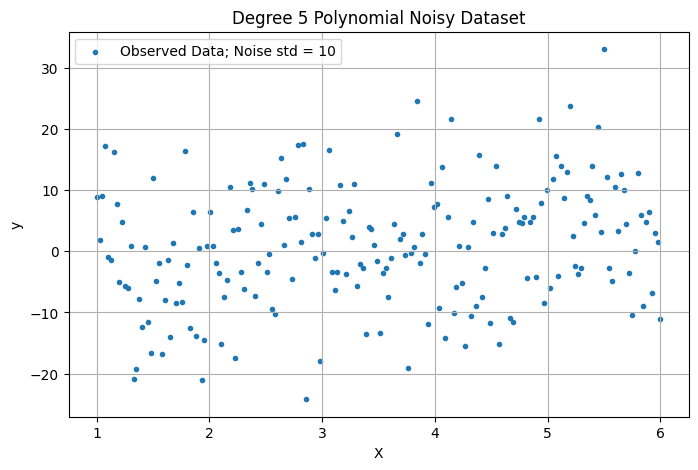

(140, 1) (60, 1) (140,) (60,)


In [99]:

# Your code here
X, y = make_poly_model(n_samples=200,degree=5,noise=10,show_data=True,show_model=False,random_state=random_state)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Test: Should print (140, 1) (60, 1) (140,) (60,)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

### Part C: Investigating the model selection problem using test/train plots

In this part, you will complete the template below to:
- Train polynomial models of degree 1 .. 10 on the training dataset just produced;
- Calculate the training MSE and the testing MSE for each model;
- Plot the MSE curves vs the model degree (see the Appendix for an example plot); and
- Print out the minimal testing MSE found, and the "best" model which produced this result. 

In the remaining parts of the problem, you will answer questions about this plot. 


Min training MSE: 78.8473 at degree 10
Min testing MSE: 90.2441 at degree 6


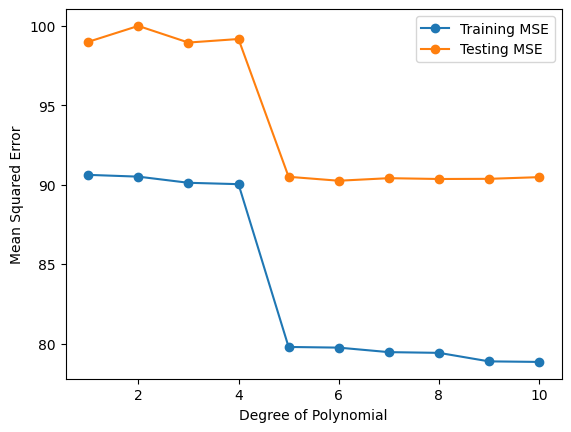

In [100]:
# Template for Problem One Part C

degrees = range(1,11) # try polynomials of these degrees
train_errors = []     # store training MSEs for each degree here
test_errors  = []     # store testing MSEs for each degree here

for d in degrees:

    # remove: just to get the cell to run without error

    # Use PolynomialFeatures to transform the data into appropriate form for
    # a polynomial model of degree d.
    poly = PolynomialFeatures(degree=d)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)

    # Fit a linear regression model on the transformed data
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Predict on the train and test sets
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)

    # Calculate the MSEs and append to the appropriate lists
    train_errors.append(mean_squared_error(y_train, y_train_pred))
    test_errors.append(mean_squared_error(y_test, y_test_pred))
    

# Plot training and test MSEs vs degree of model using train_errors and test_errors
# Note that the x axis should have ticks for 1 .. 10 only
plt.plot(degrees, train_errors, marker='o', label='Training MSE')
plt.plot(degrees, test_errors, marker='o',label='Testing MSE')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Mean Squared Error')
plt.legend()

# Calculate minimal MSE and degree for test set and print out 
# Hint: notice carefully that the MSE lists are for degrees [1, 2, 3, ....]  (i.e., index + 1)
min_train_mse = min(train_errors)
min_test_mse = min(test_errors)

min_train_mse_degree = train_errors.index(min_train_mse) + 1
min_test_mse_degree = test_errors.index(min_test_mse) + 1

print(f"Min training MSE: {min_train_mse:.4f} at degree {min_train_mse_degree}")
print(f"Min testing MSE: {min_test_mse:.4f} at degree {min_test_mse_degree}")   



### Part D: Minimum MSE 

Set the variable to the minimum test MSE found for the given parameter choices.

In [46]:

a1d = min_test_mse                              # Just to get the cell to run without errors, replace by appropriate expression

print(f'a1d = {a1d:.4f}')              # Do NOT change this print statement in any way, it is used by the auto-grader!

a1d = 90.2441


### Part E: Lower Bound for Testing MSE

The lower bound for the testing MSE is the MSE of the data points compared to
the underlying model with no noise. 

Calculate this lower bound and assign it to the variable `a1e`. 

Hint: Construct a second dataset exactly the same as the original but with noise = 0.0.

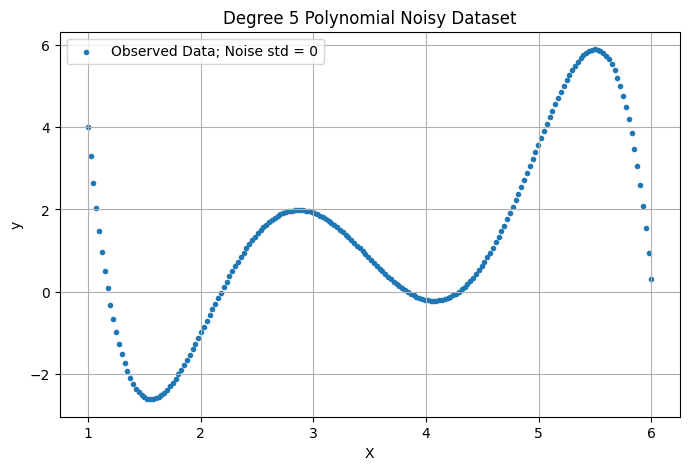

a1e = 0.0000


In [ ]:
# New dataset with 0 noise
Xe, ye = make_poly_model(n_samples=200,degree=5,noise=0,show_data=True,show_model=False,random_state=random_state)

# A polynomial model with 0 noise will have 0 testing error
a1e = 0                               # Just to get the cell to run without errors, replace by appropriate expression

print(f'a1e = {a1e:.4f}')                  # Do NOT change this print statement in any way, it is used by the auto-grader!

#### For the last two parts of this problem, you must experiment with changes to the following parameters:

- `n_samples`:  Try 10, 20, 50, 100, 200, 500, 1000
- `noise`: Try 0, 5, 10, 20, 50, 100, 500, 1000
- `random_state`: None           (then you can try multiple times with the same parameter choices)

It is sufficient for this problem to simply change each of these
separately, giving 7 + 8  = 15 trials. 

**Optional:**  For each parameter choice, try multiple times, with the random choices being different each time, by setting `random_state = None`. 

**Answer the following questions** based on these experiments. 



### Part F: Training MSE

Set the variable to the single **most correct** answer.

As the degree increases, throughout all the experiments, the training MSE appears to ...

1. Fluctuate unpredictably.
2. Never increase (gets smaller or stays the same in each step).
3. Decrease rapidly to degree 5 and then flatten out (not change much).
4. Always be higher than the test MSE.

In [92]:

a1f = 2                    # Must be one of 1, 2, 3, 4

print(f'a1f = {a1f}')         # Do NOT change this print statement in any way, it is used by the auto-grader!

a1f = 2


### Part G: Effect of Noise

Set the variable to the single **most correct** answer.

If we leave all parameters the same, except we set noise to increasingly larger values ...

1. The best degree alternates between 5 and 6. 
2. The shapes of both plots is always essentially the same, the only change being the scale of the Y axis. 
3. The least MSE increases approximately proportionally to the square of the noise. 
4. The best degree found is always the same, and the least MSE increases approximately proportionally with the noise. 

In [ ]:
# Give the degree where this minimum test MSE was found

a1g = 3                             # Must be one of 1, 2, 3, 4

print(f'a1g = {a1g}')                  # Do NOT change this print statement in any way, it is used by the auto-grader!

a1g = Ellipsis


### Optional: Run more tests, with different degrees of polynomial as well!

If you have time to try more experiments, say by changing the degree, you will see that I chose the default parameters for our investigations
with some care, because you won't always get the beautiful curves shown in the testbooks, and you won't always get the correct degree when selecting
the "best" model based on the testing MSE. 

## **Intro to Problem Two**

We have seen that we can preprocess data by constructing new features that encode **nonlinear functions** of existing features. In statistical learning theory, these transformations are often called **basis functions**. So far, we have explored only the simplest case—extending a univariate regression problem with polynomial terms like $x^2$, $x^3$, and so on. However, **any** nonlinear transformation of the features can be computed and either **added to** or **used in place of** existing features.

#### **Examples of Nonlinear Basis Functions**
#### **1. Polynomial Transforms**
So far, we have only considered the univariate case of polynomial regression, where we add new features such as $x^2, x^3, \dots$. However, with multiple features, we also generate **interaction terms** such as $x_1 x_2$.  

For example, a full quadratic polynomial regression on features $x_1$ and $x_2$ introduces three additional terms:

$$
y = \beta_0
+ \beta_1 x_1 + \beta_2 x_2
+ \underline{\beta_3 x_1^2 + \beta_4 x_2^2 + \beta_5 x_1 x_2}
$$



Since the number of terms in polynomial expansions grows very quickly, it is common to limit interactions to only a few key features.

#### **2. Log Transforms**
A logarithmic transformation—such as $\log(y)$—is useful when a feature (or the target variable) spans multiple orders of magnitude or appears to grow exponentially fast. This transformation helps stabilize variance, making relationships more linear and easier to model.

#### **3. Exponential Transforms**
In contrast to log transforms, an exponential transformation** (e.g., $2^{x_1}$) can be useful when a feature exhibits exponential decay instead of growth. This can help capture relationships where small changes in a feature have large effects on the target variable.



## Problem Two: Linear Regression with Feature Engineering on the California Housing Dataset

The transforms we will investigate in this problem, using the **CA Housing Dataset**, are as follows:

#### 2.1 Log-transform the target:

Because housing prices can vary wildly,  replace $y$ by its log-transform:

$$
    y = \log(\text{MedHouseVal}).
$$


#### 2.2 Log-transform a feature


Since  *Median Income* ranges widely, add a feature

$$
    \text{LogMedInc} = \log(\text{MedInc}).
$$


#### 2.3 Polynomial features for slight curvature

You might suspect that increasing *population* from 1,000 to 2,000 has a bigger effect on price than from 10,000 to 11,000 (diminishing returns).  
Thus, add a quadratic term to include polynomial regression on this feature:

$$
    \text{PopSquared} = (\text{Population})**2
$$


#### 2.4 Interaction features

It might be that *average rooms* matter more if *average bedrooms* is above some threshold. One way to let your linear model handle this is to add the product term:

$$\text{RoomsTimesBeds} = \text{AveRooms} \times \text{AveBedrms}. $$

In an ordinary linear regression, you’d then have something like

$$\text{MedHouseVal} \approx \beta_0 + \beta_1\,\text{AveRooms} + \beta_2\,\text{AveBedrms} + \beta_3\,\text{RoomsTimesBeds} + \dots$$

The coefficient $\beta_3$ shows how the slope for *AveRooms* depends on *AveBedrms* (and vice versa).



**Note:** The usual practice is that we **replace** the target by a new target, but **add** transformed features. In a later lesson, we will investigate **feature selection**, in which we may delete features which are insignificant or noisy. 



## Your Turn!
In this problem, you will apply feature engineering to the **California Housing Dataset** and evaluate its impact on linear regression performance.

### Part A. Load the Data  
- Code to load the dataset from `sklearn.datasets` is provided.  

### Part B. Train Regression Models & Compute Metrics  
Perform linear (multiple) regression using `MedHouseVal` as the target and compute **testing MSE and $R^2$ values** for each of the following cases:  

1. **Baseline Model** – Use the original dataset without feature engineering.  
2. **Single Transformations Models** – Apply each of the transformations (2.1–2.4) one at a time, keeping all other features unchanged (resulting in 4 models).  
3. **All Transformations Model** – Apply all transformations simultaneously and evaluate the model.  

### Part C. Summarize & Visualize Results  
- Display the results in **tabular format** showing testing MSE and $R^2$ values for all experiments (don't overthink this, but at least label and line up each column).  
- Plot results using two **bar charts** (at least give a title to each chart and label each bar).  
  - Compare the MSEs but exclude models with log-transformed target (where the MSE is in log-space and not directly comparable).  
  - Compare $R^2$ values for all models. 

### Part D. Complete Graded Questions  

 
**Note: To ensure reproducibility, always use `random_state=42` in all relevant functions.**


### Part A

In [101]:
# 1. Load the California Housing data into a DataFrame
data = fetch_california_housing(as_frame=True)
df = data.frame  # The dataset in pandas DataFrame format

df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Part B

You may create additional code cells as you wish. 

In [109]:
# Multiregression on the whole dataset without feature engineering
X_df = df.drop(columns='MedHouseVal')
y_df = df['MedHouseVal']

# Split the data into training and testing sets
X_df_train, X_df_test, y_df_train, y_df_test = train_test_split(X_df, y_df, test_size=0.25, random_state=42)

# Fit a linear regression model on the training data
model = LinearRegression()
model.fit(X_df_train, y_df_train)

# Predict on the training and testing sets
y_df_train_pred = model.predict(X_df_train)
y_df_test_pred = model.predict(X_df_test)

#Calculate the MSE and R2 of the model
mse_train = mean_squared_error(y_df_train, y_df_train_pred)
mse_test = mean_squared_error(y_df_test, y_df_test_pred)

r2_train = r2_score(y_df_train, y_df_train_pred)
r2_test = r2_score(y_df_test, y_df_test_pred)

# Print the training and test MSE and R2
print(f"Training MSE: {mse_train:.4f}, Training R2: {r2_train:.4f}")
print(f"Testing MSE: {mse_test:.4f}, Testing R2: {r2_test:.4f}")

Training MSE: 0.5206, Training R2: 0.6099
Testing MSE: 0.5411, Testing R2: 0.5911


In [111]:
# Apply Feature Engineering on the dataset
# Starting with Log transforming the target variable
y_df_log = np.log(y_df)

# Split the data into training and testing sets
X_df_train, X_df_test, y_df_log_train, y_df_log_test = train_test_split(X_df, y_df_log, test_size=0.25, random_state=42)

# Fit a linear regression model on the training data
model_y_log = LinearRegression()
model_y_log.fit(X_df_train, y_df_log_train)

# Predict on the training and testing sets
y_df_log_train_pred = model_y_log.predict(X_df_train)
y_df_log_test_pred = model_y_log.predict(X_df_test)

# Calculate the MSE and R2 of the model
mse_train_log = mean_squared_error(y_df_log_train, y_df_log_train_pred)
mse_test_log = mean_squared_error(y_df_log_test, y_df_log_test_pred)

r2_train_log = r2_score(y_df_log_train, y_df_log_train_pred)
r2_test_log = r2_score(y_df_log_test, y_df_log_test_pred)

# Print the training and test MSE and R2
print(f"Training MSE: {mse_train_log:.4f}, Training R2: {r2_train_log:.4f}")
print(f"Testing MSE: {mse_test_log:.4f}, Testing R2: {r2_test_log:.4f}")

Training MSE: 0.1237, Training R2: 0.6169
Testing MSE: 0.1295, Testing R2: 0.6044


In [112]:
# Log tranform the Median Income column
X_df_inc = X_df.copy()
X_df_inc['MedInc'] = np.log(X_df_inc['MedInc'])

# Split the data into training and test sets
X_df_inc_train, X_df_inc_test, y_df_train, y_df_test = train_test_split(X_df_inc, y_df, test_size=0.25, random_state=42)

# Fit a linear regression model on the training data
model_inc = LinearRegression()
model_inc.fit(X_df_inc_train, y_df_train)

# Predict on the training and testing sets
y_df_inc_train_pred = model_inc.predict(X_df_inc_train)
y_df_inc_test_pred = model_inc.predict(X_df_inc_test)

# Calculate the MSE and R2 of the model
mse_train_inc = mean_squared_error(y_df_train, y_df_inc_train_pred)
mse_test_inc = mean_squared_error(y_df_test, y_df_inc_test_pred)

r2_train_inc = r2_score(y_df_train, y_df_inc_train_pred)
r2_test_inc = r2_score(y_df_test, y_df_inc_test_pred)

# Print the training and test MSE and R2
print(f"Training MSE: {mse_train_inc:.4f}, Training R2: {r2_train_inc:.4f}")
print(f"Testing MSE: {mse_test_inc:.4f}, Testing R2: {r2_test_inc:.4f}")

Training MSE: 0.5926, Training R2: 0.5559
Testing MSE: 0.6000, Testing R2: 0.5466


In [113]:
# Square the population feature
X_df_pop = X_df.copy()
X_df_pop['Population'] = X_df_pop['Population']**2

# Split the data into training and test sets
X_df_pop_train, X_df_pop_test, y_df_train, y_df_test = train_test_split(X_df_pop, y_df, test_size=0.25, random_state=42)

# Fit a linear regression model on the training data
model_pop = LinearRegression()
model_pop.fit(X_df_pop_train, y_df_train)

# Predict on the training and testing sets
y_df_pop_train_pred = model_pop.predict(X_df_pop_train)
y_df_pop_test_pred = model_pop.predict(X_df_pop_test)

# Calculate the MSE and R2 of the model
mse_train_pop = mean_squared_error(y_df_train, y_df_pop_train_pred)
mse_test_pop = mean_squared_error(y_df_test, y_df_pop_test_pred)

r2_train_pop = r2_score(y_df_train, y_df_pop_train_pred)
r2_test_pop = r2_score(y_df_test, y_df_pop_test_pred)

# Print the training and test MSE and R2
print(f"Training MSE: {mse_train_pop:.4f}, Training R2: {r2_train_pop:.4f}")
print(f"Testing MSE: {mse_test_pop:.4f}, Testing R2: {r2_test_pop:.4f}")

Training MSE: 0.5206, Training R2: 0.6099
Testing MSE: 0.5412, Testing R2: 0.5910


In [114]:
# Create a new feature called RoomsxBeds
X_df_roomsbeds = X_df.copy()
X_df_roomsbeds['RoomsxBeds'] = X_df_roomsbeds['AveRooms'] * X_df_roomsbeds['AveBedrms']

# Split the data into training and test sets
X_df_roomsbeds_train, X_df_roomsbeds_test, y_df_train, y_df_test = train_test_split(X_df_roomsbeds, y_df, test_size=0.25, random_state=42)

# Fit a linear regression model on the training data
model_roomsbeds = LinearRegression()
model_roomsbeds.fit(X_df_roomsbeds_train, y_df_train)

# Predict on the training and testing sets
y_df_roomsbeds_train_pred = model_roomsbeds.predict(X_df_roomsbeds_train)
y_df_roomsbeds_test_pred = model_roomsbeds.predict(X_df_roomsbeds_test)

# Calculate the MSE and R2 of the model
mse_train_roomsbeds = mean_squared_error(y_df_train, y_df_roomsbeds_train_pred)
mse_test_roomsbeds = mean_squared_error(y_df_test, y_df_roomsbeds_test_pred)

r2_train_roomsbeds = r2_score(y_df_train, y_df_roomsbeds_train_pred)
r2_test_roomsbeds = r2_score(y_df_test, y_df_roomsbeds_test_pred)

# Print the training and test MSE and R2
print(f"Training MSE: {mse_train_roomsbeds:.4f}, Training R2: {r2_train_roomsbeds:.4f}")
print(f"Testing MSE: {mse_test_roomsbeds:.4f}, Testing R2: {r2_test_roomsbeds:.4f}")

Training MSE: 0.5205, Training R2: 0.6099
Testing MSE: 0.5443, Testing R2: 0.5886


In [115]:
# Apply all transformations on the dataset
X_df_all = X_df.copy()
X_df_all['MedInc'] = np.log(X_df_all['MedInc'])
X_df_all['Population'] = X_df_all['Population']**2
X_df_all['RoomsxBeds'] = X_df_all['AveRooms'] * X_df_all['AveBedrms']

# Split the data into training and test sets
X_df_all_train, X_df_all_test, y_df_log_train, y_df_log_test = train_test_split(X_df_all, y_df_log, test_size=0.25, random_state=42)

# Fit a linear regression model on the training data
model_all = LinearRegression()
model_all.fit(X_df_all_train, y_df_log_train)

# Predict on the training and testing sets
y_df_all_train_pred = model_all.predict(X_df_all_train)
y_df_all_test_pred = model_all.predict(X_df_all_test)

# Calculate the MSE and R2 of the model
mse_train_all = mean_squared_error(y_df_log_train, y_df_all_train_pred)
mse_test_all = mean_squared_error(y_df_log_test, y_df_all_test_pred)

r2_train_all = r2_score(y_df_log_train, y_df_all_train_pred)
r2_test_all = r2_score(y_df_log_test, y_df_all_test_pred)

# Print the training and test MSE and R2
print(f"Training MSE: {mse_train_all:.4f}, Training R2: {r2_train_all:.4f}")
print(f"Testing MSE: {mse_test_all:.4f}, Testing R2: {r2_test_all:.4f}")


Training MSE: 0.1198, Training R2: 0.6289
Testing MSE: 0.1245, Testing R2: 0.6197


### Part C

In [ ]:
# Create an lists of all the MSEs and R2s
training_mses = [mse_train, mse_train_log, mse_train_inc, mse_train_pop, mse_train_roomsbeds, mse_train_all]
testing_mses = [mse_test, mse_test_log, mse_test_inc, mse_test_pop, mse_test_roomsbeds, mse_test_all]
training_r2s = [r2_train, r2_train_log, r2_train_inc, r2_train_pop, r2_train_roomsbeds, r2_train_all]
testing_r2s = [r2_test, r2_test_log, r2_test_inc, r2_test_pop, r2_test_roomsbeds, r2_test_all]

# create a Dataframe to store the results
results_df = pd.DataFrame({'Training MSE': training_mses, 'Testing MSE': testing_mses, 'Training R2': training_r2s, 'Testing R2': testing_r2s},
                          index=['No Feature Engineering', 'Log Transform Target', 'Log Transform Median Income', 'Square Population', 'Rooms x Beds', 'All Transformations'])

results_df

,Training MSE,Testing MSE,Training R2,Testing R2
No Feature Engineering,0.520552,0.541129,0.609873,0.591051
Log Transform Target,0.123651,0.129481,0.616904,0.604364
Log Transform Median Income,0.592603,0.599997,0.555875,0.546562
Square Population,0.520554,0.541170,0.609871,0.591020
Rooms x Beds,0.520522,0.544308,0.609896,0.588649
All Transformations,0.119775,0.124476,0.628914,0.619658


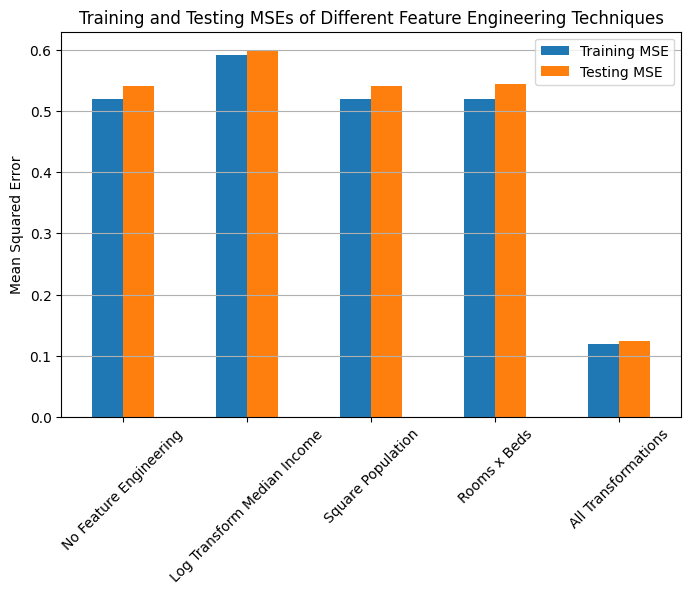

In [120]:
# Plot the MSEs
mse_df = results_df.drop(index='Log Transform Target')
plt.figure(figsize=(8,5))
mse_df[['Training MSE', 'Testing MSE']].plot(kind='bar', ax=plt.gca())
plt.ylabel('Mean Squared Error')
plt.title('Training and Testing MSEs of Different Feature Engineering Techniques')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


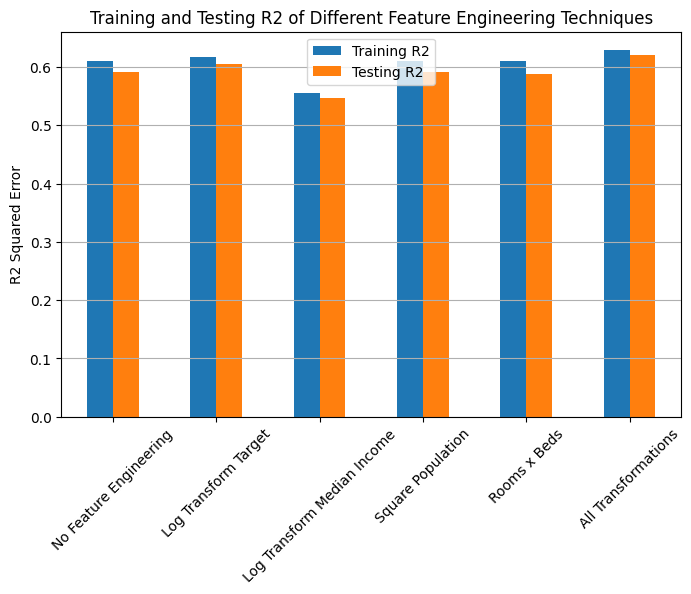

In [ ]:
# Plot the R2s
plt.figure(figsize=(8,5))
results_df[['Training R2', 'Testing R2']].plot(kind='bar', ax=plt.gca())
plt.ylabel('R2 Squared Error')
plt.title('Training and Testing R2 of Different Feature Engineering Techniques')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

### Part D: Graded answers


In [ ]:
# Assign to the variable the MSE of the original data set with no transformations

a2d1 =                             # Just to get the cell to run without errors, replace by appropriate expression

print(f'a2d1 = {a2d1:.4f}')             # Do NOT change this print statement in any way, it is used by the auto-grader!

a2d1 = 0.0000


In [13]:
# Assign to the variable the MSE  score of the dataset after transformation 2.3

a2d2 = 0.0                              # Just to get the cell to run without errors, replace by appropriate expression

print(f'a2d2 = {a2d2:.4f}')             # Do NOT change this print statement in any way, it is used by the auto-grader!

a2d2 = 0.0000


In [14]:
# Assign to the variable the $R^2$  score of the dataset after transformation 2.1


a2d3 = 0.0                              # Just to get the cell to run without errors, replace by appropriate expression

print(f'a2d3 = {a2d3:.4f}')             # Do NOT change this print statement in any way, it is used by the auto-grader!

a2d3 = 0.0000


In [15]:
# Assign to the variable the R^2 score of the best result, i.e., the best R^2 score found in any experiment
# Note that you do not have to specify which experiment(s), just give the largest value.

a2d4 = 0.0                              # Just to get the cell to run without errors, replace by appropriate expression

print(f'a2d4 = {a2d4:.4f}')             # Do NOT change this print statement in any way, it is used by the auto-grader!

a2d4 = 0.0000


### Part E

In [16]:
# How many hours did you spend on this homework?  Assign to the variable an integer value. 

a2e = ...                         # Just to get the cell to run without errors, replace by appropriate expression

print(f'a2e = {a2e}')             # Do NOT change this print statement in any way, it is used by the auto-grader!

a2e = Ellipsis


## Appendix

Here is a sample of the graphic I expect in Problem One. 

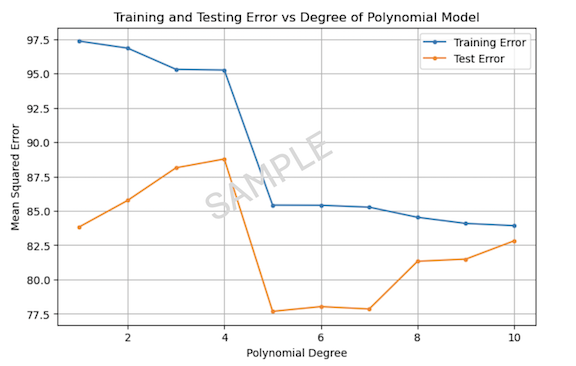